### Economic Geography of Interwar Poland
This notebook uses the administrative database and files with economic data to compute the GDP of Interwar Poland on the district level and present an overview of the Polish economic geography in the Interwar Period.

It is a showcase of the use of the whole toolkit. An instance of the AdministrativeHistory class constructed with inputs describing administrative history is used as an API that allows to access, impute, and harmonize data in the database. In the mature form of the toolkit, a PostgreSQL database with economic data will be created and hosted online and a pip-installable package called interwar_poland_database will be publicly shared. The pip package will reconstruct the administrative base locally, and will connect as a read-only-user to the PostgreSQL database to import the necessary data. In this preliminary version of the toolkit, the economic data is stored in the CSV form.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Necessary imports
import pandas as pd
from utils.helper_functions import load_config
from core.core import AdministrativeHistory
from utils.helper_functions import extract_date_parts

In [3]:
plots_output_path = "E:/Studia/Studia magisterskie/Masterarbeit - Wirtschaftwissenschaft/data_plots"

In [4]:
# Load the configuration
config = load_config("config.json")

# Create an administrative history object
administrative_history = AdministrativeHistory(config, load_geometries=True)

Loading changes list...
✅ Loaded 302 validated changes in 0.07 seconds.
Loading initial state...
✅ Loaded initial state.
Loading initial district registry...
✅ Loaded 292 validated districts in 0.03 seconds. Set their initial state timespands to (1921-02-19, 1939-09-01).
Loading initial region registry...
✅ Loaded 19 validated regions in 0.00 seconds. Set their initial state timespands to (1921-02-19, 1939-09-01)
Creating administrative history (sequentially applying changes)...
✅ Successfully applied all changes in 10.57 seconds. Administrative history database created.
Loading territories...
Loaded: powiaty_1921_corrected_names.shp (276 rows)
Loaded: powiaty_1931_corrected_names.shp (283 rows)
Loaded: powiaty_1938_corrected_names_modified.shp (264 rows)
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 

In [5]:
# Use administrative history to harmonize all the input data tables to one administrative state
# administrative_history.harmonize_data()
# administrative_history.post_organization_reorganize_data_tables()

In [6]:
example_df, example_data_table_metadata, example_adm_state_date = administrative_history.load_data_table(data_table_id = 'dist_area_baseline_adm_state', version='harmonized')

df.columns after renaming: Index(['District', 'Area: Together'], dtype='object')


In [7]:
example_df

,District,Area: Together
0,AUGUSTOWSKI,583358.239631
1,BARANOWICKI,910704.277600
2,BIALSKI (BIAŁA KRAKOWSKA),149602.877287
3,BIALSKI (BIAŁA PODLASKA),559800.629145
4,BIAŁOSTOCKI,857773.133856
...,...,...
259,ŚWIĘTOCHŁOWICKI,19757.727968
260,ŻNIŃSKI,203073.553135
261,ŻYDACZOWSKI,205450.395794
262,ŻYWIECKI,272741.573148


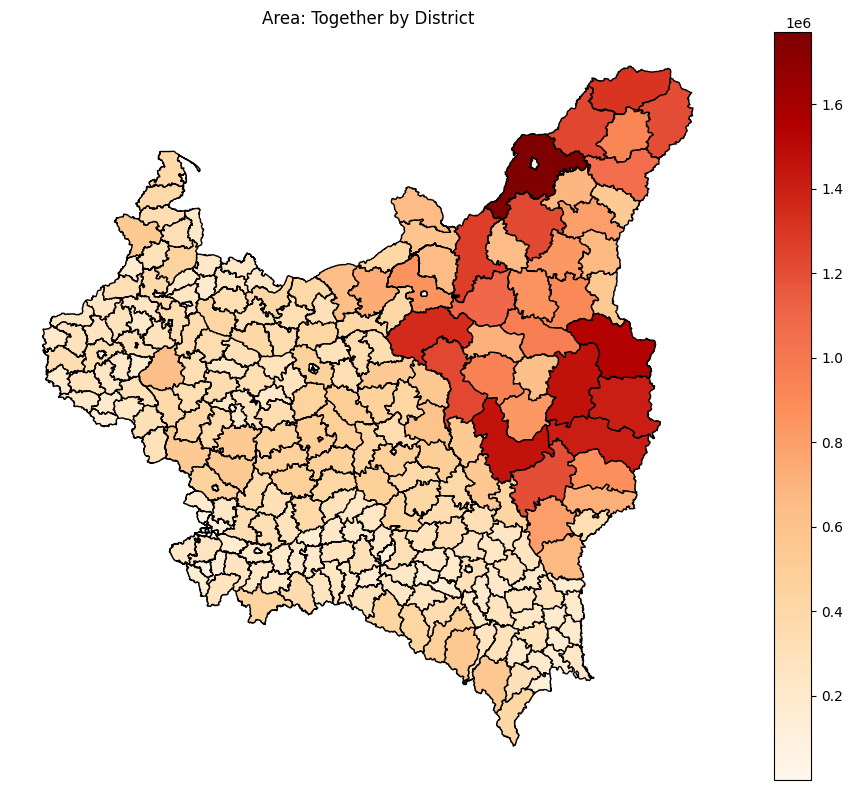

In [8]:
administrative_history.plot_dataset(df = example_df, col_name = 'Area: Together', adm_level='District', adm_state_date=example_adm_state_date)

### Total Crop Value

Load crop prices for 5 main crops:
- 'Pszenica',
- 'Żyto',
- 'Jęczmień',
- 'Owies',
- 'Ziemniaki'.

In cases where prices of multiple crop subtypes are given, I choose:
- 'Ziemniaki: Jadalne', where 'Ziemniaki: Jadalne' and 'Ziemniaki: Fabryczne' are given,
- 'Jęczmień: Browarny', where 'Jęczmień: Browarny', and 'Jęczmień: Innych gatunków' or 'Jęczmień: Na kaszę' are given.

In [11]:
columns_to_select = ['District', 'Pszenica: Together', 'Żyto: Together', 'Jęczmień: Together', 'Jęczmień: Ogółem', 'Owies: Together', 'Ziemniaki: Together', 'Ziemniaki: Jadalne', 'Jęczmień: Browarny']
# Load the crops size
crops_prices_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Crops prices']
crops_prices_dfs = [administrative_history.load_data_table(data_table_id = crops_data_table_id, version = 'harmonized') for crops_data_table_id in crops_prices_data_table_ids]
crops_prices_year_df_pairs = [(extract_date_parts(metadata.date)[0], df) for df, metadata, date in crops_prices_dfs if extract_date_parts(metadata.date)[1] == '08' or extract_date_parts(metadata.date)[0] is None]
crops_prices_year_df_clean = []
for year, df in crops_prices_year_df_pairs:
    existing_columns = [col for col in columns_to_select if col in df.columns]
    df = df[existing_columns]
    df.columns = [col.split(':')[0].strip() for col in df.columns]
    crops_prices_year_df_clean.append((year, df))

Load crops yields data

In [17]:
# Load the crops prices
columns_to_select = ['District', 'Pszenica: Together', 'Żyto: Together', 'Jęczmień: Together', 'Owies: Together', 'Ziemniaki: Together']
crops_size_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Crops - Size']
crops_size_dfs = [administrative_history.load_data_table(data_table_id = crops_data_table_id, version = 'harmonized') for crops_data_table_id in crops_size_data_table_ids]
crops_size_year_df_pairs = [(extract_date_parts(metadata.date)[0], df) for df, metadata, date in crops_size_dfs]
crops_size_year_df_clean = []
for year, df in crops_size_year_df_pairs:
    existing_columns = [col for col in columns_to_select if col in df.columns]
    df = df[existing_columns]
    df.columns = [col.split(':')[0].strip() for col in df.columns]
    crops_size_year_df_clean.append((year, df))

### Compute Total Crop Value

In [31]:
import pandas as pd

results = {}

# Build a dictionary for easy year-based access
yields_by_year = {year: df for year, df in crops_size_year_df_clean}
prices_by_year = {year: df for year, df in crops_prices_year_df_clean}

# Find years present in both datasets
common_years = sorted(set(yields_by_year.keys()) & set(prices_by_year.keys()))

for year in common_years:
    yield_df = yields_by_year[year]
    price_df = prices_by_year[year]

    # Ensure both have the same crops (columns minus 'District')
    crop_cols = [col for col in yield_df.columns if col != 'District']
    crop_cols_price = [col for col in price_df.columns if col != 'District']

    if set(crop_cols) != set(crop_cols_price):
        raise ValueError(f"Crop mismatch in year {year}:\nYield: {crop_cols}\nPrice: {crop_cols_price}")

    crop_cols.sort()  # Just to be sure order matches
    price_df = price_df[['District'] + crop_cols]
    yield_df = yield_df[['District'] + crop_cols]

    # Merge on District
    merged = pd.merge(price_df, yield_df, on='District', suffixes=('_price', '_yield'))

    # Calculate total crop value for each row
    crop_value = sum(
        merged[f"{crop}_price"] * merged[f"{crop}_yield"]
        for crop in crop_cols
    )

    result_df = pd.DataFrame({
        'District': merged['District'],
        '5 Main Crops Value': crop_value
    })

    result_df['5 Main Crops Value %'] = 100*(result_df[['5 Main Crops Value']]/result_df[['5 Main Crops Value']].max())

    results[year] = result_df


Generate and save plots with total livestock units.

In [32]:

for year, df in results.items():
    plot_path = plots_output_path + f"/5_Crops_Value_{year}.png"
    administrative_history.plot_dataset(df = df, col_name = '5 Main Crops Value %', adm_level='District', adm_state_date=administrative_history.harmonize_to_date, save_to_path=plot_path, title = f'5 Main Crops Value (% of max. district value) ({year})')

### Livestock data

In [33]:
# Load livestock datasets
livestock_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Livestock']
livestock_dfs = [administrative_history.load_data_table(data_table_id = livestock_data_table_id, version = 'harmonized') for livestock_data_table_id in livestock_data_table_ids]
livestock_year_df_pairs = [(extract_date_parts(metadata.date)[0], df) for df, metadata, date in livestock_dfs]
# Add Livestock_Units column
for year, df in livestock_year_df_pairs:
    horses = df['Konie: Together']
    cows = df['Bydło rogate: Together']
    pigs = df['Trzoda chlewna: Together'] / 4

    if 'Owce i kozy: Together' in df.columns:
        sheep_goats = df['Owce i kozy: Together'] / 10
        livestock_units = horses + cows + pigs + sheep_goats
    else:
        goats = df.get('Kozy: Together', 0) / 10
        sheep = df.get('Owce: Together', 0) / 10
        livestock_units = horses + cows + pigs + goats + sheep

    df['Livestock_Units'] = livestock_units

Generate and save plots with total livestock units.

In [35]:
for year, df in livestock_year_df_pairs:
    print(df.columns)
    plot_path = plots_output_path + f"/Livestock_Units_{year}.png"
    administrative_history.plot_dataset(df = df, col_name = 'Livestock_Units', adm_level='District', adm_state_date=administrative_history.harmonize_to_date, save_to_path=plot_path, title = f'Livestock Units ({year})', legend_min = 0, legend_max = 250000)

Index(['District', 'Konie: Together', 'Bydło rogate: Together',
       'Trzoda chlewna: Together', 'Owce: Together', 'Kozy: Together',
       'Livestock_Units'],
      dtype='object')
Index(['District', 'Konie: Together', 'Bydło rogate: Together',
       'Trzoda chlewna: Together', 'Owce i kozy: Together', 'Livestock_Units'],
      dtype='object')
Index(['District', 'Konie: Together', 'Bydło rogate: Together',
       'Trzoda chlewna: Together', 'Owce: Together', 'Kozy: Together',
       'Livestock_Units'],
      dtype='object')
Index(['District', 'Konie: Together', 'Bydło rogate: Together',
       'Trzoda chlewna: Together', 'Owce: Together', 'Kozy: Together',
       'Livestock_Units'],
      dtype='object')
Index(['District', 'Konie: Together', 'Bydło rogate: Together',
       'Trzoda chlewna: Together', 'Owce: Together', 'Kozy: Together',
       'Livestock_Units'],
      dtype='object')


e:\Studia\Studia magisterskie\Masterarbeit - Wirtschaftwissenschaft\dane\Digitalizacja\border_harmonization_toolkit\core\core.py:1337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 8))


Index(['District', 'Konie: Together', 'Bydło rogate: Together',
       'Trzoda chlewna: Together', 'Owce: Together', 'Kozy: Together',
       'Livestock_Units'],
      dtype='object')
Index(['District', 'Konie: Together', 'Bydło rogate: Together',
       'Trzoda chlewna: Together', 'Owce: Together', 'Kozy: Together',
       'Livestock_Units'],
      dtype='object')
Index(['District', 'Konie: Together', 'Bydło rogate: Together',
       'Trzoda chlewna: Together', 'Owce: Together', 'Kozy: Together',
       'Livestock_Units'],
      dtype='object')
Index(['District', 'Konie: Together', 'Bydło rogate: Together',
       'Trzoda chlewna: Together', 'Owce: Together', 'Kozy: Together',
       'Livestock_Units'],
      dtype='object')
Index(['District', 'Konie: Together', 'Bydło rogate: Together',
       'Trzoda chlewna: Together', 'Owce: Together', 'Kozy: Together',
       'Livestock_Units'],
      dtype='object')


In [ ]:
forests_data_table, forests_metadata, forests_date = administrative_history.load_data_table(data_table_id = '1930-forests_area_ha_ready', version = 'harmonized')
forests_data_table.rename(columns={'Area: Together': 'Total Forest Area'}, inplace = True)
dist_area_data_table, dist_area_metadata, dist_area_date = administrative_history.load_data_table(data_table_id = 'dist_area_baseline_adm_state', version = 'harmonized')
dist_area_data_table.rename(columns={'Area: Together': 'Total District Area'}, inplace = True)
forests_data_table = forests_data_table.merge(dist_area_data_table, on='District', how='left')
forests_data_table['Forest as District Area Proportion'] = forests_data_table['Total Forest Area']/forests_data_table['Total District Area']

Index(['District', 'Total Forest Area'], dtype='object')
Index(['District', 'Total District Area'], dtype='object')
Index(['District', 'Total Forest Area', 'Total District Area'], dtype='object')


Generate and save plots with forest area and forest area in comparison to .

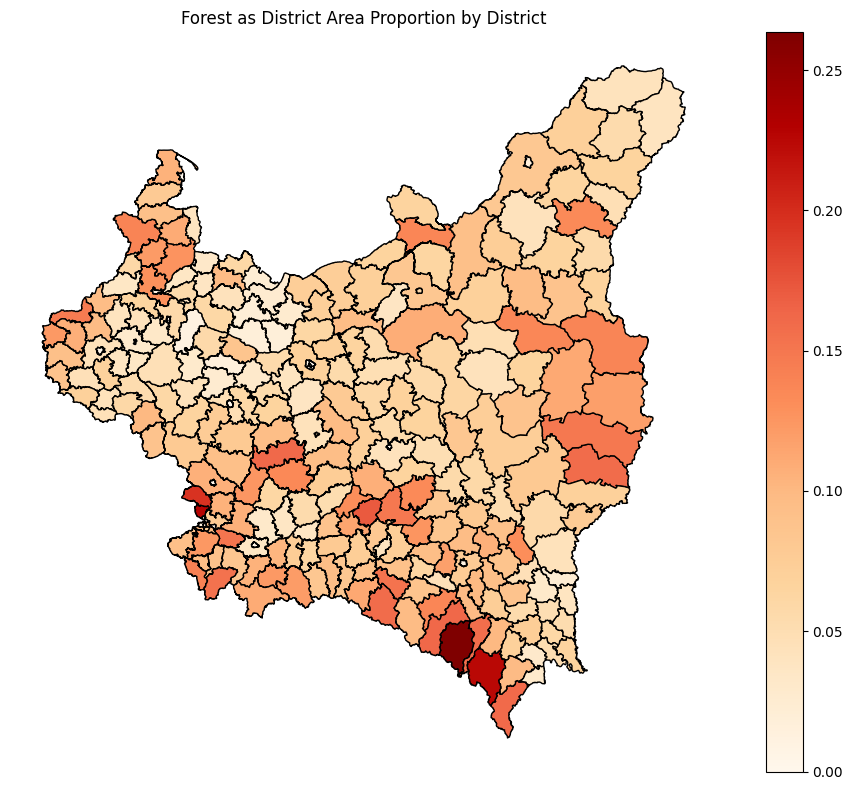

In [ ]:
# Plot total forest area:
plot_path = plots_output_path + f"/Total_Forest_Area_{year}.png"
administrative_history.plot_dataset(df = forests_data_table, col_name = 'Total Forest Area', adm_level='District', adm_state_date=example_adm_state_date, save_to_path=plot_path, title = 'Total Forest Area (1930)')

# Plot proportion of forest area to district area:
plot_path = plots_output_path + f"/Proportion_of_Forest_Area_{year}.png"
administrative_history.plot_dataset(df = forests_data_table, col_name = 'Forest as District Area Proportion', adm_level='District', adm_state_date=example_adm_state_date, save_to_path=plot_path, title = 'Forest as District Area Proportion (1930)')

In [5]:
_, data_table_metadata_dict, _ = administrative_history.load_data_table(data_table_id = '1934-crops_q_ready', version = 'original')
input_csv_path = administrative_history.data_harmonization_input_folder + data_table_metadata_dict.data_table_id + ".csv"
output_csv_path = administrative_history.data_harmonization_output_folder + data_table_metadata_dict.data_table_id + ".csv"

Attempting to read: input/harmonization_input/data/1934-crops_q_ready.csv
Ellipsis
Successfully read CSV using encoding: cp1250
df.columns before renaming: Index(['District', 'Pszenica', 'Żyto', 'Jęczmień', 'Owies', 'Ziemniaki'], dtype='object')
df.columns after renaming: Index(['District', 'Pszenica: Together', 'Żyto: Together',
       'Jęczmień: Together', 'Owies: Together', 'Ziemniaki: Together'],
      dtype='object')


In [6]:
administrative_history.harmonize_csv_file(
                    input_csv_path=input_csv_path,
                    output_csv_path=output_csv_path,
                    data_table_metadata_dict=data_table_metadata_dict,
                    date_to=administrative_history.harmonize_to_date
                )

Harmonizing csv file 'input/harmonization_input/data/1934-crops_q_ready.csv' from 1934-10-07 to 1938-04-01.
Original borders: <AdministrativeState timespan=(1934-07-23, 1937-04-01), regions=19, districts=282>.
Target borders: <AdministrativeState timespan=(1938-04-01, 1938-10-01), regions=19, districts=282>.
Attempting to read: input/harmonization_input/data/1934-crops_q_ready.csv
Ellipsis
Successfully read CSV using encoding: cp1250
⏳ Building conversion matrix from 1934-10-07 to 1938-04-01...
Constructing conversion matrix between two administrative states:
Administrative State from: <AdministrativeState timespan=(1934-07-23, 1937-04-01), regions=19, districts=282>
Administrative State to: <AdministrativeState timespan=(1938-04-01, 1938-10-01), regions=19, districts=282>
Constructing conversion dict between adm. states valid for dates 1934-10-07 and 1938-04-01
Searching districts related by territory to the district AUGUSTOWSKI.
Adding district 'AUGUSTOWSKI' state (1921-02-19, 1939-0

DataTableMetadata(data_table_id='1934-crops_q_ready', category='Crops - Size', source='Statystyka Rolnicza 1934 (Tom IV) (Warszawa 1935)', link='https://statlibr.stat.gov.pl/exlibris/aleph/a22_1/apache_media/XR7QGU6DIR588G31LYPPK1E15QTLP3.pdf', table='11. Powierzchnia zasiewów i zbiory według powiatów. 1934.', page=18, pdf_page=27, description={'pol': 'Zbiory ziemiopłodów.', 'eng': 'Harvest of crops.'}, date='30.08.1934', orig_adm_state_date=datetime.datetime(1934, 10, 7, 0, 0), adm_state_date=datetime.datetime(1938, 4, 1, 0, 0), standardization_comments='', harmonization_method='proportional_to_territory', imputation_method=None, columns={'Jęczmień': ColumnMetadata(unit='quintal', subcategory='Jęczmień', subsubcategory='Together', data_type='float', completeness=0.9128787878787878, n_na=23, n_not_na=241, completeness_after_imputation=None, n_na_after_imputation=None, n_not_na_after_imputation=None), 'Owies': ColumnMetadata(unit='quintal', subcategory='Owies', subsubcategory='Together'